In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-scoring/sample_submission.csv
/kaggle/input/sf-scoring/train.csv
/kaggle/input/sf-scoring/test.csv


In [2]:
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore")

In [3]:
DATA_DIR = '/kaggle/input/sf-scoring/'
df_train = pd.read_csv(DATA_DIR + '/train.csv')
df_test = pd.read_csv(DATA_DIR + '/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['default'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [5]:
data.sample(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
28042       3856  10JAN2014       GRD   F   32   N        N                0   
83646      78105  26MAR2014       PGR   M   34   N        N                0   
7881       45261  21FEB2014       SCH   F   32   N        N                0   
4178       53248  02MAR2014       SCH   F   43   Y        N                0   
36194      34402  10FEB2014       SCH   M   50   Y        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
28042          1  -2.898089                0             50             1   
83646          0  -2.022442                3             70             1   
7881           1  -2.385081                0             50             2   
4178           0  -1.717250                2             40             1   
36194          0  -2.223853                0             40             1   

       work_address  income  sna  first_time foreign_passport  sample  default  
28042             1   12000    1           2                N       0        0  
83646             2   86000    4           3                N       1        0  
7881              3   45000    4           1                N       0        0  
4178              2  100000    1           4                N       0        0  
36194             2   25000    1           4                N       0        0

# Список признаков
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отклонённых в прошлом заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту (наша целевая переменная)

# Составим отчет pandas profiling

In [6]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Далее расмотрим каждую переменну отдельно

### client_id
* столбец уникальных идентификаторов клиента
* вероятно не несет полезной информации для модели

In [7]:
data = data.drop('client_id', axis=1)

### app_date
* преобразуем в формат datetime
* данные представлены всего за 4 месяца
* пока  удалим столбец


In [8]:
data.app_date = data.app_date.apply(pd.to_datetime)

In [9]:
data.app_date.sort_values()

32219    2014-01-01
48827    2014-01-01
99141    2014-01-01
14209    2014-01-01
100585   2014-01-01
            ...    
91400    2014-04-30
80416    2014-04-30
50524    2014-04-30
20299    2014-04-30
42268    2014-04-30
Name: app_date, Length: 110148, dtype: datetime64[ns]

In [10]:
data = data.drop('app_date', axis=1)

### education
* единственный столбец с пропусками
* пропуски составляют всего 0.4% от общего количества
* наиболее распостраненное значение переменной 'SCH' 52.7% 
* заменим пропуски модой
* наибольшая вероятность дефолта наблюдается у категорий 'SCH' = 10.07% и 'UGR' = 8.75%

In [11]:
data.education.fillna(data.education.mode()[0], inplace=True)

education  default
ACD        0          97.250859
           1           2.749141
GRD        0          93.945582
           1           6.054418
PGR        0          95.656836
           1           4.343164
SCH        0          89.932622
           1          10.067378
UGR        0          91.246271
           1           8.753729
Name: default, dtype: float64


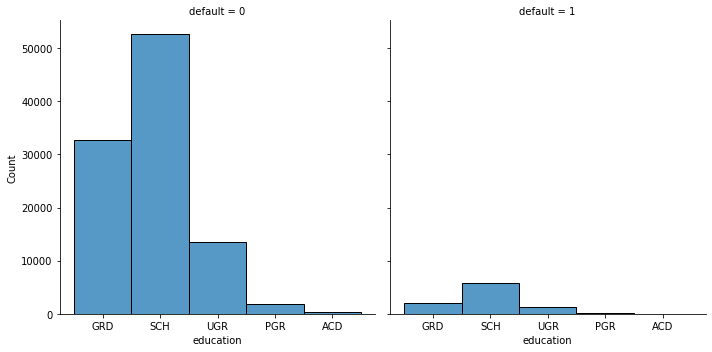

In [12]:
sns.displot(data, x="education", col="default", bins=5)
print(data.groupby(['education'])['default'].value_counts(normalize=True)*100)

### sex
* доля женщин в выборке больше мужчин и составляет 56.1%
* при этом вероятность дефолта у мужчин чем у женщин на 0.82%

sex  default
F    0          91.851025
     1           8.148975
M    0          91.031214
     1           8.968786
Name: default, dtype: float64


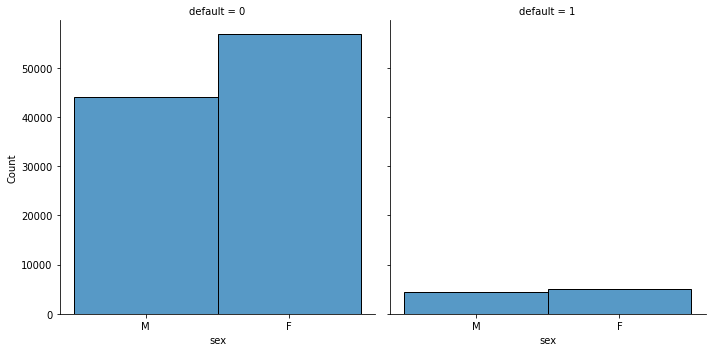

In [13]:
sns.displot(data, x="sex", col="default", bins=2)
print(data.groupby(['sex'])['default'].value_counts(normalize=True)*100)

### age
* Наиболее часто за кредитом обращаются в возрасте от 30 до 48 лет
* Средний возраст заемщика 39 лет
* прологорифмируем признак

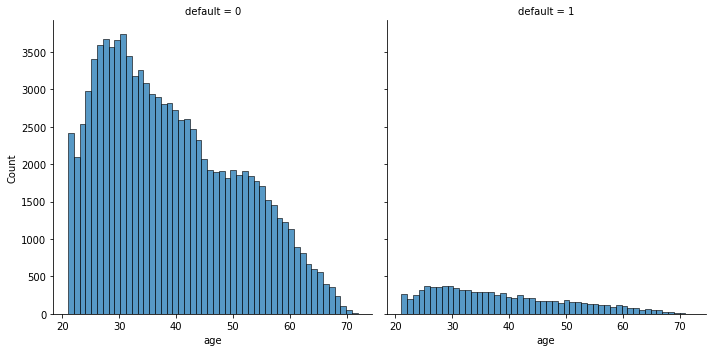

In [14]:
sns.displot(data, x="age", col="default", bins=50)

In [15]:
data.age = np.log(data.age + 1)

### car & car_type
* признаки сильно скоррелированы
* при этом видим что вероятность дефолта сильнее снижается у владельцев иномарок 
* оставим признак car_type

car  default
N    0          90.813030
     1           9.186970
Y    0          92.896983
     1           7.103017
Name: default, dtype: float64


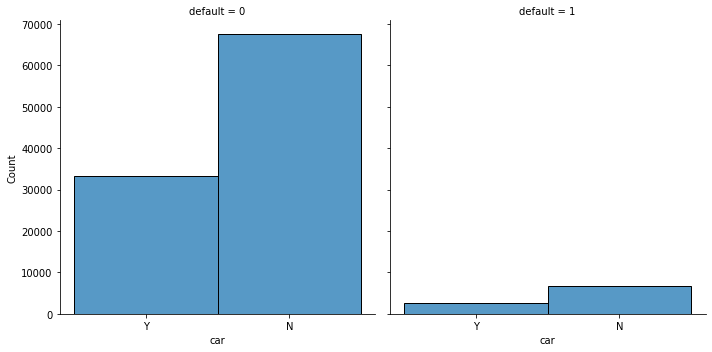

In [16]:
sns.displot(data, x="car", col="default", bins=2)
print(data.groupby(['car'])['default'].value_counts(normalize=True)*100)

car_type  default
N         0          90.860444
          1           9.139556
Y         0          94.168888
          1           5.831112
Name: default, dtype: float64


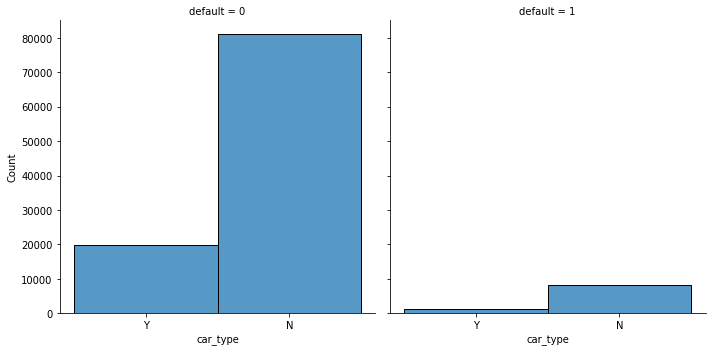

In [17]:
sns.displot(data, x="car_type", col="default", bins=2)
print(data.groupby(['car_type'])['default'].value_counts(normalize=True)*100)

In [18]:
data = data.drop('car', axis=1)

### decline_app_cnt
* 83% значений равны 0
* логарифмирование несколько улучшает картину


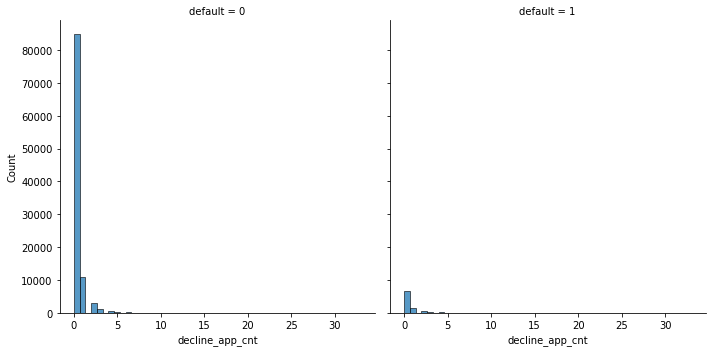

In [19]:
sns.displot(data, x="decline_app_cnt", col="default", bins=50)

In [20]:
data.decline_app_cnt = np.log(data.decline_app_cnt + 1)

### good_work
* Можно отметить что наличие хорошей работы положительно сказывается на вероятность дефолта

good_work  default
0          0          91.054974
           1           8.945026
1          0          93.692063
           1           6.307937
Name: default, dtype: float64


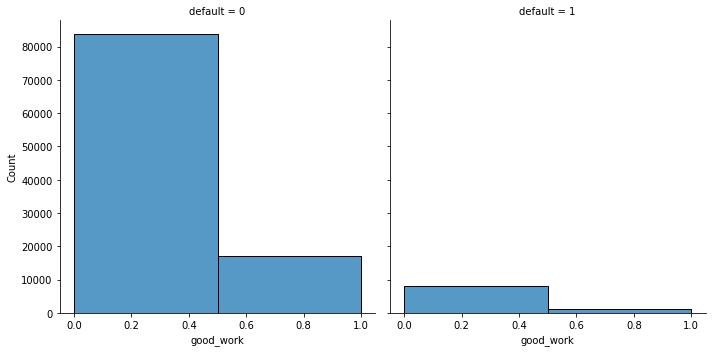

In [21]:
sns.displot(data, x="good_work", col="default", bins=2)
print(data.groupby(['good_work'])['default'].value_counts(normalize=True)*100)

### score_bki
* Видим нормальное распределение показателя
* среднее значение -1.9
* При этом 99.9% значений отрицательны

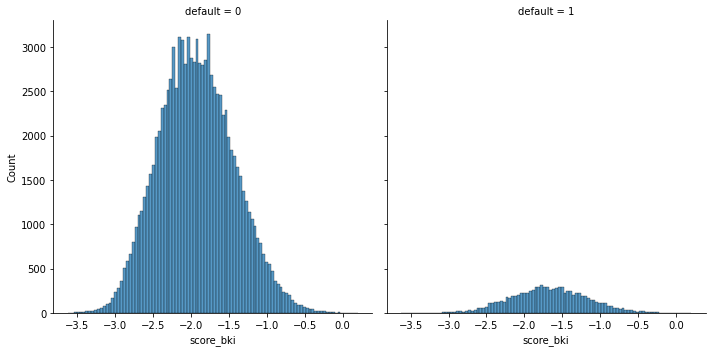

In [22]:
sns.displot(data, x="score_bki", col="default", bins=100)

### bki_request_cnt
* Медиана = 1, а среднее 2
* при этом максимальное значение 53
* есть смысл прологорифмировать переменную и сгрупировать значения

In [23]:
#data.bki_request_cnt[data.bki_request_cnt > 16] = 16
#data.bki_request_cnt[data.bki_request_cnt.between(11, 15)] = 11
#data.bki_request_cnt[data.bki_request_cnt.between(8, 10)] = 8
#data.bki_request_cnt[data.bki_request_cnt.between(4, 7)] = 4

In [24]:
data.bki_request_cnt = np.log(data.bki_request_cnt + 1)

bki_request_cnt  default
0.000000         0           93.631521
                 1            6.368479
0.693147         0           92.046162
                 1            7.953838
1.098612         0           91.113715
                               ...    
3.737670         1          100.000000
3.828641         1          100.000000
3.850148         1          100.000000
3.871201         0          100.000000
3.988984         0          100.000000
Name: default, Length: 68, dtype: float64


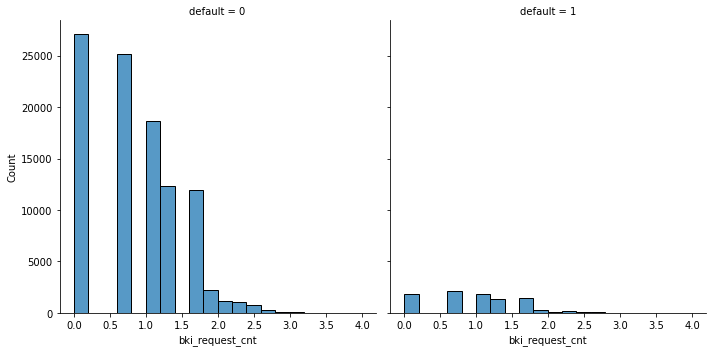

In [25]:
sns.displot(data, x="bki_request_cnt", col="default", bins=20)
print(data.groupby(['bki_request_cnt'])[
      'default'].value_counts(normalize=True)*100)

### region_rating
* Видим зависимость снижения риска дефолта от увеличения рейтинга региона

region_rating  default
20             0          85.942492
               1          14.057508
30             0          86.866359
               1          13.133641
40             0          88.627626
               1          11.372374
50             0          90.856738
               1           9.143262
60             0          91.370474
               1           8.629526
70             0          93.841359
               1           6.158641
80             0          95.113570
               1           4.886430
Name: default, dtype: float64


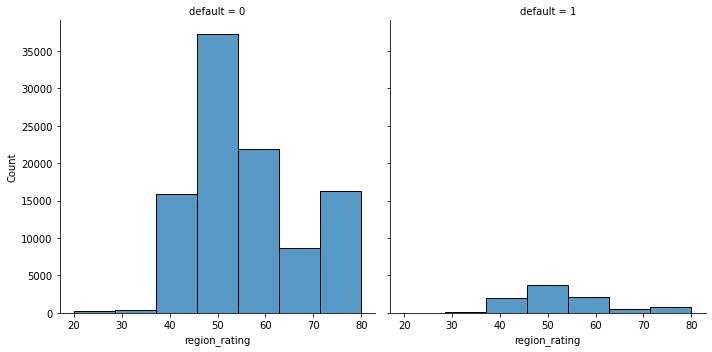

In [26]:
sns.displot(data, x="region_rating", col="default", bins=7)
print(data.groupby(['region_rating'])[
      'default'].value_counts(normalize=True)*100)

### home_address & work_address
* признаки сильно скоррелированны
* при этом стоит отметить не линейную зависимость с целевой переменной показателя home_adress

home_address  default
1             0          93.782862
              1           6.217138
2             0          89.597422
              1          10.402578
3             0          92.188336
              1           7.811664
Name: default, dtype: float64


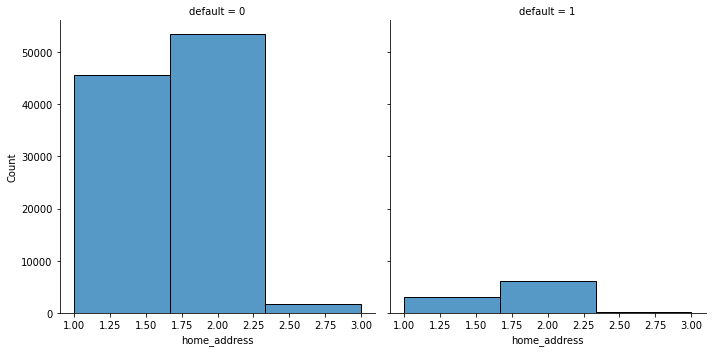

In [27]:
sns.displot(data, x="home_address", col="default", bins=3)
print(data.groupby(['home_address'])[
      'default'].value_counts(normalize=True)*100)

work_address  default
1             0          94.964967
              1           5.035033
2             0          93.166672
              1           6.833328
3             0          90.088358
              1           9.911642
Name: default, dtype: float64


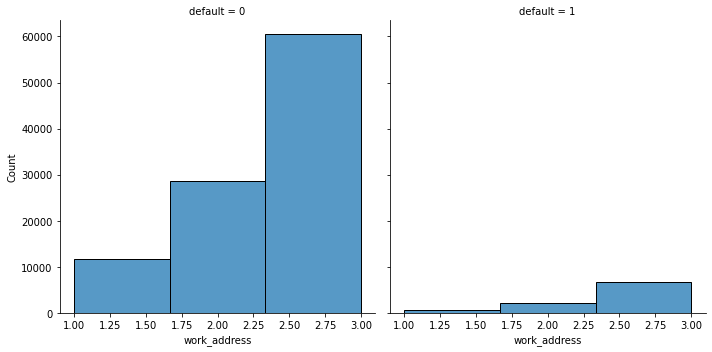

In [28]:
sns.displot(data, x="work_address", col="default", bins=3)
print(data.groupby(['work_address'])[
      'default'].value_counts(normalize=True)*100)

### income
* большинство значений находятся в пределах от 20000 да 48000
* при этом мы наблюдаем очень большое значение среднеквадратического отклонения
* в выборку поппали люди с очень большим доходом
* стоит прологарифмировать показатель

In [29]:
data.income = np.log(data.income + 1)

### sna
* значения показателя 2 и 3 имеют близкую вероятность дефолта
* признак сильно скоррелирован с признаком first_time

sna  default
1    0          93.428220
     1           6.571780
2    0          89.944416
     1          10.055584
3    0          89.437764
     1          10.562236
4    0          85.784566
     1          14.215434
Name: default, dtype: float64


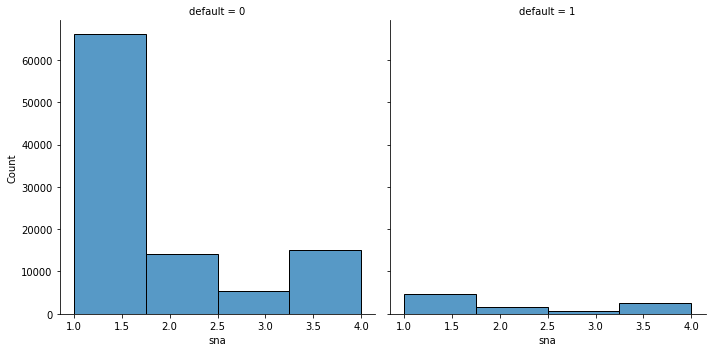

In [30]:
sns.displot(data, x="sna", col="default", bins=4)
print(data.groupby(['sna'])['default'].value_counts(normalize=True)*100)

### first_time
* можем проследить обратную за висимость вероятности дефолта
* признак сильно скоррелирован с признаком sna

first_time  default
1           0          87.549191
            1          12.450809
2           0          89.574999
            1          10.425001
3           0          91.931399
            1           8.068601
4           0          94.514045
            1           5.485955
Name: default, dtype: float64


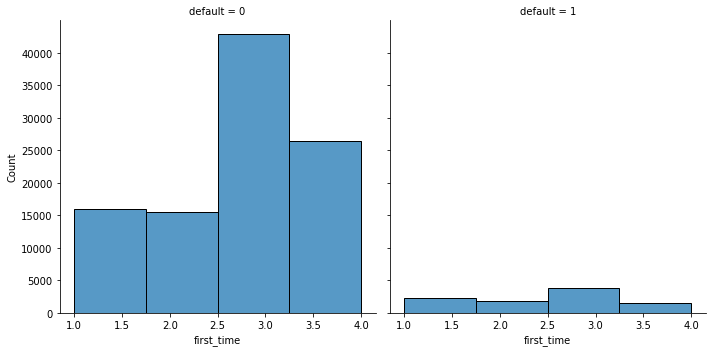

In [31]:
sns.displot(data, x="first_time", col="default", bins=4)
print(data.groupby(['first_time'])['default'].value_counts(normalize=True)*100)

### foreign_passport
* вероятность дефолта у людей с загранпаспортом почти в два раза ниже

foreign_passport  default
N                 0          90.875044
                  1           9.124956
Y                 0          95.008218
                  1           4.991782
Name: default, dtype: float64


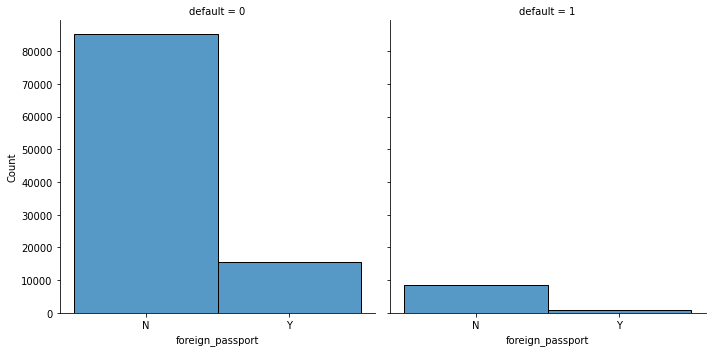

In [32]:
sns.displot(data, x="foreign_passport", col="default", bins=4)
print(data.groupby(['foreign_passport'])[
      'default'].value_counts(normalize=True)*100)

### default
* наша целевая переменная
* видим что выборка не сбалансированна, отношение примерно 1:10

In [33]:
data.default.value_counts(normalize=True)

0    0.914914
1    0.085086
Name: default, dtype: float64

In [34]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna',
            'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car_type', 'good_work', 'foreign_passport']

### Числовые переменные

<AxesSubplot:>

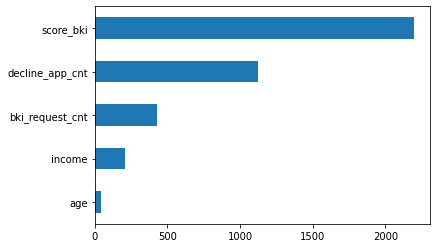

In [35]:
# Оценка значимости числовых признаков
imp_num = pd.Series(f_classif((data[num_cols]), data['default'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [36]:
from sklearn.preprocessing import StandardScaler

for column in num_cols:
    data[column] = StandardScaler().fit_transform(
        np.array(data[column].values).reshape(-1, 1))

### Преобразуем категориальные и бинарные переменные

In [37]:
label_encoder = LabelEncoder()

for i in bin_cols:
    data[i] = label_encoder.fit_transform(data[i])

data['education'] = label_encoder.fit_transform(data['education'])

<AxesSubplot:>

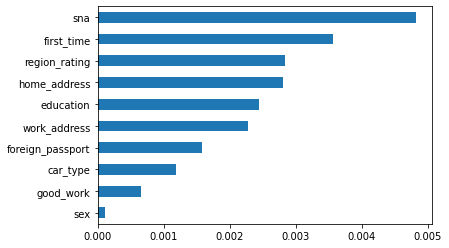

In [38]:
# Оценка значимости бинарных и категориальных признаков
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

### Удалим скоррелированные менее значимые признаки

In [39]:
data = data.drop(['first_time', 'work_address'], axis=1)

In [40]:
# Разобьем на отдельные признаки
cat_cols = ['education', 'sna', 'home_address', 'region_rating']
new = pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(
    data[cat_cols].values)).astype(int)
data = pd.concat([data.drop(cat_cols, axis=1), new], axis=1)

# Построение модели

In [41]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

### Отбалансируем выборку


In [42]:
smote = SMOTE(sampling_strategy=1, random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

In [43]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, shuffle=True, random_state=42)

### подберем оптимальные параметры

In [44]:
random_seed = 42
C = np.logspace(-2, 1, 10)
iter_ = 100
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'],
     'C': C,
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'],
     # 'C': C,
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'],
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'],
     'class_weight':['none', 'balanced'],
     'C': C,
     'solver': ['saga'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
'''
model = LogisticRegression(random_state=random_seed)


# Обучаем модель
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')
'''

"\nmodel = LogisticRegression(random_state=random_seed)\n\n\n# Обучаем модель\ngridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)\ngridsearch.fit(X_train, y_train)\nmodel_best_params = gridsearch.best_estimator_\n\n# Печатаем параметры\nbest_params = model_best_params.get_params()\nprint(f'Лучшие значения параметров:') \nfor param_name in best_params.keys():\n        print(f'  {param_name} = {best_params[param_name]},')\n"

Лучшие значения параметров:
  C = 0.021544346900318832,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 100,
  multi_class = auto,
  n_jobs = None,
  penalty = l1,
  random_state = 42,
  solver = liblinear,
  tol = 0.001,
  verbose = 0,
  warm_start = False,

In [45]:
logreg = LogisticRegression(C=0.021544346900318832,
                            class_weight='balanced',
                            dual=False,
                            fit_intercept=True,
                            intercept_scaling=1,
                            l1_ratio=None,
                            max_iter=100,
                            multi_class='auto',
                            n_jobs=None,
                            penalty='l1',
                            random_state=42,
                            solver='liblinear',
                            tol=0.001,
                            verbose=0,
                            warm_start=False)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [46]:
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.73      0.74      0.74     12877
           1       0.74      0.73      0.73     12894

    accuracy                           0.74     25771
   macro avg       0.74      0.74      0.74     25771
weighted avg       0.74      0.74      0.74     25771



# Submission

In [47]:
predict_submission = logreg.predict(test_data)

In [48]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

client_id  default
0      74835        0
1      17527        1
2      75683        0
3      26883        0
4      28862        0
5      99881        0
6      26630        1
7      79934        0
8      16605        0
9     105449        0

In [49]:
sample_submission.describe()

client_id       default
count   36349.000000  36349.000000
mean    54945.647473      0.298825
std     31706.052195      0.457749
min         4.000000      0.000000
25%     27744.000000      0.000000
50%     54657.000000      0.000000
75%     82322.000000      1.000000
max    110148.000000      1.000000

In [50]:
!kaggle competitions submit - c sf-scoring - f ssubmission.csv - m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
